In [102]:
from math import sin, cos, pi, sqrt, e, log, isclose, exp
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm, pyplot as plt

import h5py
from scipy.constants import epsilon_0, mu_0
import scipy.constants

import Levenshtein as lev
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from fdtd_PCB_extensions.tissue import cole_cole_4, complex_permittivity_to_er_and_sigma, electric_field_penetration_depth


TODO: Verify that k is of the right units in every other location

First, what is the threshold excitation that Yang found? It's eq.11, 

$$P_{stress} = 0.141 \text{MPa} = \frac{2 k A}{0.58 \pi r^2}$$

$$ A = \frac{29 P \pi r^2}{100 k} $$



In [103]:
P = 141000

r = 50.0e-9
k = 70.30 # from Yang
A_threshold = (29.0 * P * r**2.0) / (100 * k)

A_threshold

1.454125177809388e-12

In [3]:
b = 6.031857894892403e-10

In [429]:

tissue_properties_database_file = '../biology/FDTD/itis_tissue_properties/SEMCAD_v14.8.h5'

tissue_obj = 0
f = h5py.File(tissue_properties_database_file,'r')
#Fuzzy matching names - keep a close eye on this, errors could creep in!
virtprop_name = "Muscle"
matching_name = process.extractOne(virtprop_name,f['Tissues'].keys())
print(f"Fuzzy-matched tissue {virtprop_name} to {matching_name[0]}")

tissue_obj = f['Tissues'][matching_name[0]]


taus = np.array([0]*4,dtype=np.float)
alphas = np.array([0]*4,dtype=np.float)
deltas = np.array([0]*4,dtype=np.float)

taus[0] = tissue_obj.attrs["tau1"]
taus[1] = tissue_obj.attrs["tau2"]
taus[2] = tissue_obj.attrs["tau3"]
taus[3] = tissue_obj.attrs["tau4"]

# Tau values in the tissueprop files are normalized
# Tau1 is normalized by 1e-12
# tau2 1e-9
# tau3 1e-6
# tau4 1e-3
tau_normalization_factors = np.array([1e-12, 1e-9, 1e-6, 1e-3])
# all other constants are not normalized.
taus *= tau_normalization_factors

alphas[0] = tissue_obj.attrs["alf1"]
alphas[1] = tissue_obj.attrs["alf2"]
alphas[2] = tissue_obj.attrs["alf3"]
alphas[3] = tissue_obj.attrs["alf4"]

deltas[0] = tissue_obj.attrs["del1"]
deltas[1] = tissue_obj.attrs["del2"]
deltas[2] = tissue_obj.attrs["del3"]
deltas[3] = tissue_obj.attrs["del4"]

sigma = tissue_obj.attrs["sig"]
ef = tissue_obj.attrs["ef"]



Fuzzy-matched tissue Muscle to Muscle


We want to know: using the formalism in \cite{Detection2003}, 
    
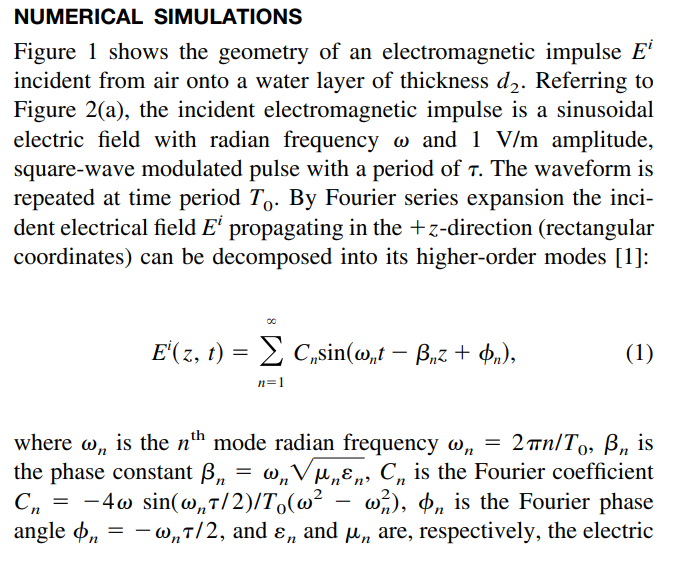


We first pre-compute all the constants for each mode.

In [430]:
def brillouin_series(x, t, b, Cs, omegas, betas, phis, gammas):
    RHS = Cs * np.sin(omegas*t - betas*x + phis) * np.exp(-1.0 * (x / gammas))
    RHS = np.sum(RHS, axis=0)
    
    return RHS


In [431]:
def brillouin_constants(sine_fundamental_period, repeat_period, pulse_period, N_modes):
    

    
    n = np.arange(1, N_modes+1, 10)
    
    omegas = 2 * pi * n / repeat_period
    
    print(omegas)
    dielectric_constants = np.zeros_like(n, dtype=np.float)
    E_penetration_depths = np.zeros_like(n, dtype=np.float)

    for idx,mode in enumerate(omegas):
        cole_cole_properties = cole_cole_4((mode/(2.0*pi)), ef, sigma, deltas, alphas, taus)
        dielectric_constant, conductivity = complex_permittivity_to_er_and_sigma(cole_cole_properties, mode)
        dielectric_constants[idx] = dielectric_constant
        E_penetration_depth = electric_field_penetration_depth(mode, dielectric_constant, conductivity)
        E_penetration_depths[idx] = E_penetration_depth
    # this is not valid.


    gammas = E_penetration_depths
    
    
    betas = omegas * np.sqrt(mu_0 * epsilon_0 * dielectric_constants)
    omega = (2 * pi * (1.0/sine_fundamental_period))


    
    #here be dragons - which way around is this?
    Cs = (-4.0 * omega * np.sin(omegas*pulse_period/2.0) / (repeat_period * (omega**2.0 - omegas**2.0)))
    
    phis = - omegas * pulse_period / 2.0
    
    return np.array(Cs), np.array(omegas), np.array(betas), np.array(phis), np.array(gammas)




[4.188790e+08 4.607669e+09 8.796459e+09 ... 2.974041e+10 3.392920e+10
 3.811799e+10]


[6.283185e+10 6.911504e+11 1.319469e+12 ... 4.461062e+12 5.089380e+12
 5.717699e+12]
2.0960142247829832e-42


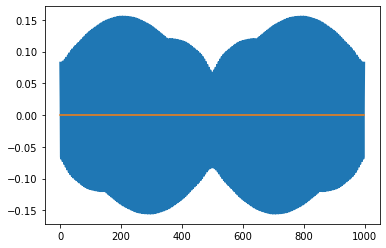

In [456]:
sine_fundamental_period = 1.0/(50e9)
repeat_period = 1.0/(10e9)
pulse_period = 1.0/(20e9)
N_modes = 100

Cs, omegas, betas, phis, gammas = brillouin_constants(sine_fundamental_period, repeat_period, pulse_period, N_modes)


t = np.linspace(0, 200e-10, 1000)

# Cs = np.meshgrid(t, Cs)
# omegas = np.meshgrid(t, omegas)
# betas = np.meshgrid(t, betas)

near = []
far = []

x = 0.0
for i in t:
    near.append(brillouin_series(x, i, b, Cs, omegas, betas, phis, gammas))
    
x = 0.05
for i in t:
    far.append(brillouin_series(x, i, b, Cs, omegas, betas, phis, gammas))
    
    
plt.plot(near)
plt.plot(far)

print(np.max(far))



0.8898249227005951 7.066650217740298e-09


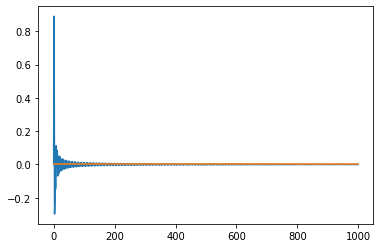

In [438]:
def simple_dispersion(t, x, modes):

    omegas = 2 * pi * modes

    dielectric_constants = np.zeros_like(modes, dtype=np.float)
    E_penetration_depths = np.zeros_like(modes, dtype=np.float)

    for idx,mode in enumerate(modes):
        cole_cole_properties = cole_cole_4(mode, ef, sigma, deltas, alphas, taus)
        dielectric_constant, conductivity = complex_permittivity_to_er_and_sigma(cole_cole_properties, mode)
        dielectric_constants[idx] = dielectric_constant
        E_penetration_depth = electric_field_penetration_depth(mode, dielectric_constant, conductivity)
        E_penetration_depths[idx] = E_penetration_depth


    gammas = E_penetration_depths


    betas = omegas * np.sqrt(mu_0 * epsilon_0 * dielectric_constants)

    
    RHS = np.sin(omegas*t - betas*x) * np.exp(-1.0 * (x / gammas))
    RHS = np.sum(RHS, axis=0)
    
    RHS /= len(modes)
    
    return RHS



t = np.linspace(0, 10e-9, 1000)

near = []
far = []

modes = np.linspace(10e9, 30e9, 1000)

x = 0.0
for i in t:
    near.append(simple_dispersion(i, x, modes))
    
x = 0.05
for i in t:
    far.append(simple_dispersion(i, x, modes))
    
# near /= np.max(near)

plt.plot(near)
plt.plot(far)

print(np.max(near) , np.max(far))

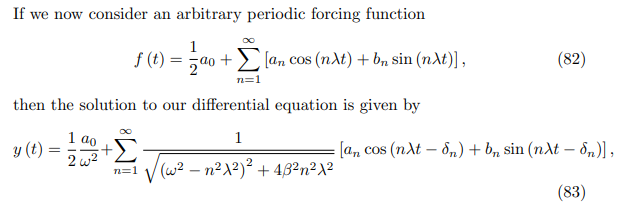



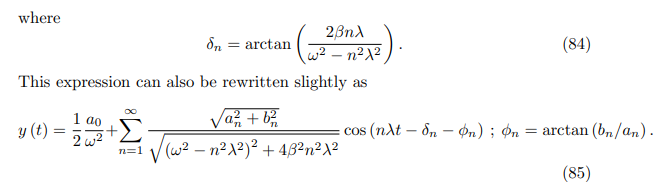

the fact that there are /two/ representative frequencies makes me a bit wary of using this verbatim. 

Using the DE from Yang,

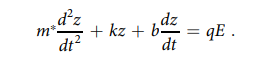

Switching coordinate systems to 'x' as distance from the transmitter, and 'z' for the oscillation of the virus,

$$m^* \frac{d^2z}{dt^2} + kz + b \frac{d z}{dt} = \sum_{1}^{N} \left( Cs_n \sin(\omega_n t - \beta_n x + \phi_n)  \exp{\left( -\frac{x}{\gamma_n} \right)} \right)$$

where $\gamma_n$ is the n-th electric field penetration depth, N is the number of harmonics considered,

It seems like this should just be a simple linear combination of the solutions for each mode - but since I didn't pay attention in Prof. Gold's great differential equations class and Maxima refuses to provide a useful result, we cop out and integrate numerically.

We re-arrange for a first-order DE,

(see https://sam-dolan.staff.shef.ac.uk/mas212/notebooks/ODE_Example.html)


$$z = U[0] \ \ p = z' = U[1]$$

$$m^* \frac{dp}{dt} + kz + b p = \sum_{1}^{N} \left( Cs_n \sin(\omega_n t - \beta_n x + \phi_n)  \exp{\left( -\frac{x}{\gamma_n} \right)} \right)$$


$$\frac{dp}{dt} = \frac{\sum_{1}^{N} \left( Cs_n \sin(\omega_n t - \beta_n x + \phi_n)  \exp{\left( -\frac{x}{\gamma_n} \right)} \right) - kz - b p}{m^*} $$



In [14]:
def diff_eq(U, t, x, b, m_prime, k, Cs, omegas, betas, phis, gammas):
    
    z = U[0]
    p = U[1] 
    
    RHS = brillouin_series(x, b, Cs, omegas, betas, phis, gammas)
    
    LHS = - k*z  - b*p
    
    return [p, ((RHS - LHS)/m_prime)]
    
